# Generate Digital Painting Images with DCGAN

**Hi! This is the code I developed for my undergraduate thesis to obtain my S.Kom degree.**

The purpose of my thesis was to implement the Deep Convolutional Generative Adversarial Network (DCGAN) algorithm to generate automatic digital painting images. As we know, The demand for digital painting images continues to increase in this digital era. Due to the difficulties in acquiring knowledge and skills, as well as the time and cost involved in producing traditional art, artists face challenges. Therefore, technology is needed to automatically generate new and diverse art paintings.

The Deep Convolutional Generative Adversarial Network (DCGAN) algorithm can assist artists in creating art more efficiently. DCGAN consists of a discriminator and a generator network. The discriminator aims to distinguish between real and generated samples, while the generator tries to produce fake samples, fooling the discriminator into believing they are real.

This research conducted experiments by modifying image sizes to 32x32, 64x64, and 128x128 pixels, with 4, 5, and 6 layers. This source code is the best experiment of 9 experiments conducted which is using 32x32 image size and 5 convolutional layers achieved the best performance, with the smallest generator loss value (4.8795) among the other experiments.

[Data Source](https://google.github.io/cartoonset/index.html)


## Exploring the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil
folder_paths = [x[0] for x in os.walk('/content/drive/MyDrive/Image Processing/GAN')]

In [ ]:
folder_paths

['/content/drive/MyDrive/Image Processing/GAN',
 '/content/drive/MyDrive/Image Processing/GAN/0',
 '/content/drive/MyDrive/Image Processing/GAN/1',
 '/content/drive/MyDrive/Image Processing/GAN/2',
 '/content/drive/MyDrive/Image Processing/GAN/3',
 '/content/drive/MyDrive/Image Processing/GAN/4',
 '/content/drive/MyDrive/Image Processing/GAN/5']

In [ ]:
# Extract the folders names from the paths
artists = [os.path.basename(path).replace('_', ' ') for path in folder_paths[1:]]

# Print the list of folders
print(artists)

['0', '1', '2', '3', '4', '5']


In [ ]:
DATA_DIR = '/content/paintings/images'

if not os.path.exists(DATA_DIR):
  os.makedirs(DATA_DIR)

for folder_path in folder_paths:
  for filename in os.listdir(folder_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):
      src_path = os.path.join(folder_path, filename)
      dst_path = os.path.join(DATA_DIR, filename)
      shutil.copy(src_path, dst_path)

In [ ]:
valid_extensions = ('.jpg', '.png')

# Get the list of all files in the folder with valid extensions
files = [file for file in os.listdir(DATA_DIR) if file.endswith(valid_extensions)]

# Print the total number of images in the folder
print(f'Total number of images in {DATA_DIR}: {len(files)}')

Total number of images in /content/paintings/images: 57838


In [ ]:
print(os.listdir(DATA_DIR)[:10])

['cs1416079017964514624.jpg', 'cs13129418041517285155.jpg', 'cs11642271500921945281.jpg', 'cs2423159578819388102.jpg', 'cs13240397482063270707.jpg', 'cs16102299904276718846.jpg', 'cs3925428940012020560.jpg', 'cs2448848613852561012.jpg', 'cs13074707230251676205.jpg', 'cs12860897457959625157.jpg']


In [ ]:
folder_path = DATA_DIR

total_width = 0
total_height = 0
num_images = 0

# loop through all images in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        # open the image
        image = Image.open(os.path.join(folder_path, filename))

        # get the shape (dimensions) of the image
        width, height = image.size

        # accumulate the total width and height
        total_width += width
        total_height += height

        # increment the number of images
        num_images += 1

# calculate the mean dimensions
mean_width = total_width / num_images
mean_height = total_height / num_images

# print the mean dimensions
print(f"The mean dimensions of the {num_images} images are {mean_width}x{mean_height}")

The mean dimensions of the 57838 images are 500.0x500.0


In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [ ]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
train_ds = ImageFolder('/content/paintings', transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

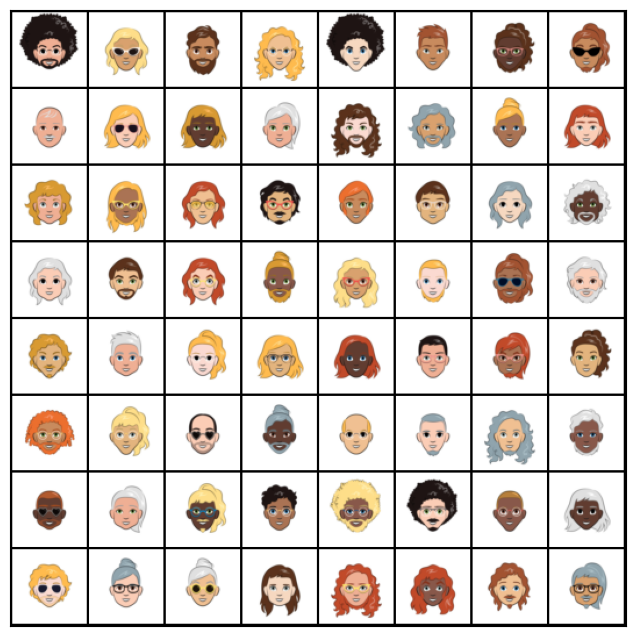

In [ ]:
show_batch(train_dl)

## Using a GPU

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

## Discriminator Network

In [ ]:
import torch.nn as nn

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
discriminator = to_device(discriminator, device)

## Generator Network

In [ ]:
latent_size = 128

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


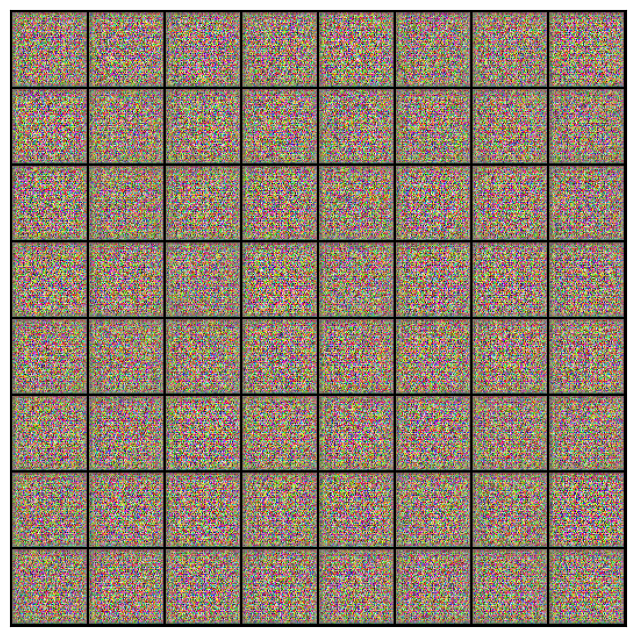

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

As one might expect, the output from the generator is basically random noise, since we haven't trained it yet.

Let's move the generator to the chosen device.

In [ ]:
generator = to_device(generator, device)

## Discriminator Training

In [ ]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

## Generator Training

In [ ]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [ ]:
from torchvision.utils import save_image

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


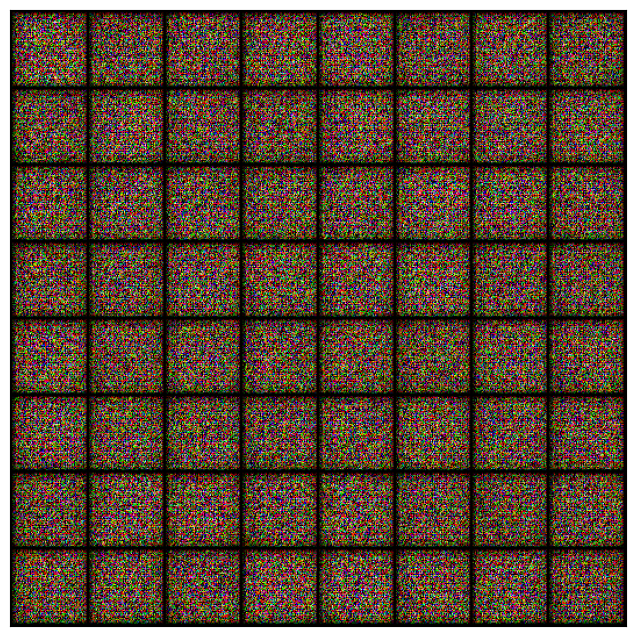

In [ ]:
save_samples(0, fixed_latent)

## Full Training Loop

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
lr = 0.0002
epochs = 50

In [ ]:
history = fit(epochs, lr)

  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [1/50], loss_g: 5.0005, loss_d: 0.2589, real_score: 0.9740, fake_score: 0.1872
Saving generated-images-0001.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [2/50], loss_g: 4.7590, loss_d: 0.1778, real_score: 0.9305, fake_score: 0.0958
Saving generated-images-0002.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [3/50], loss_g: 4.3623, loss_d: 0.0411, real_score: 0.9837, fake_score: 0.0239
Saving generated-images-0003.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [4/50], loss_g: 5.2861, loss_d: 0.2708, real_score: 0.9613, fake_score: 0.1341
Saving generated-images-0004.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [5/50], loss_g: 7.1315, loss_d: 0.0201, real_score: 0.9867, fake_score: 0.0063
Saving generated-images-0005.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [6/50], loss_g: 7.2897, loss_d: 0.0156, real_score: 0.9984, fake_score: 0.0137
Saving generated-images-0006.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [7/50], loss_g: 5.7485, loss_d: 0.0676, real_score: 0.9890, fake_score: 0.0525
Saving generated-images-0007.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [8/50], loss_g: 5.0208, loss_d: 0.0232, real_score: 0.9960, fake_score: 0.0188
Saving generated-images-0008.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [9/50], loss_g: 3.8698, loss_d: 0.0801, real_score: 0.9330, fake_score: 0.0071
Saving generated-images-0009.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [10/50], loss_g: 5.1505, loss_d: 0.0210, real_score: 0.9913, fake_score: 0.0120
Saving generated-images-0010.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [11/50], loss_g: 6.0036, loss_d: 0.0306, real_score: 0.9821, fake_score: 0.0114
Saving generated-images-0011.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [12/50], loss_g: 4.7941, loss_d: 0.0484, real_score: 0.9908, fake_score: 0.0369
Saving generated-images-0012.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [13/50], loss_g: 5.2529, loss_d: 0.0247, real_score: 0.9800, fake_score: 0.0039
Saving generated-images-0013.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [14/50], loss_g: 4.6043, loss_d: 0.0516, real_score: 0.9554, fake_score: 0.0040
Saving generated-images-0014.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [15/50], loss_g: 6.2087, loss_d: 0.0075, real_score: 0.9981, fake_score: 0.0055
Saving generated-images-0015.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [16/50], loss_g: 6.7006, loss_d: 0.0128, real_score: 0.9956, fake_score: 0.0083
Saving generated-images-0016.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [17/50], loss_g: 4.1839, loss_d: 0.0422, real_score: 0.9977, fake_score: 0.0384
Saving generated-images-0017.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [18/50], loss_g: 7.1626, loss_d: 0.0140, real_score: 0.9894, fake_score: 0.0031
Saving generated-images-0018.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [19/50], loss_g: 5.6162, loss_d: 0.0237, real_score: 0.9815, fake_score: 0.0045
Saving generated-images-0019.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [20/50], loss_g: 6.1917, loss_d: 0.0762, real_score: 0.9909, fake_score: 0.0630
Saving generated-images-0020.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [21/50], loss_g: 6.1559, loss_d: 0.0719, real_score: 0.9969, fake_score: 0.0640
Saving generated-images-0021.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [22/50], loss_g: 4.3028, loss_d: 0.0410, real_score: 0.9782, fake_score: 0.0174
Saving generated-images-0022.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [23/50], loss_g: 5.7602, loss_d: 0.0714, real_score: 0.9715, fake_score: 0.0403
Saving generated-images-0023.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [24/50], loss_g: 8.7100, loss_d: 0.1002, real_score: 0.9916, fake_score: 0.0846
Saving generated-images-0024.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [25/50], loss_g: 4.5248, loss_d: 0.0246, real_score: 0.9799, fake_score: 0.0027
Saving generated-images-0025.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [26/50], loss_g: 2.7730, loss_d: 0.1352, real_score: 0.8912, fake_score: 0.0037
Saving generated-images-0026.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [27/50], loss_g: 6.2423, loss_d: 0.0035, real_score: 0.9989, fake_score: 0.0024
Saving generated-images-0027.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [28/50], loss_g: 6.5760, loss_d: 0.0059, real_score: 0.9980, fake_score: 0.0039
Saving generated-images-0028.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [29/50], loss_g: 7.2837, loss_d: 0.0237, real_score: 0.9966, fake_score: 0.0183
Saving generated-images-0029.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [30/50], loss_g: 6.2878, loss_d: 0.0099, real_score: 0.9919, fake_score: 0.0016
Saving generated-images-0030.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [31/50], loss_g: 4.1411, loss_d: 0.0896, real_score: 0.9317, fake_score: 0.0111
Saving generated-images-0031.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [32/50], loss_g: 6.4007, loss_d: 0.0117, real_score: 0.9993, fake_score: 0.0102
Saving generated-images-0032.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [33/50], loss_g: 5.3277, loss_d: 0.0097, real_score: 0.9930, fake_score: 0.0026
Saving generated-images-0033.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [34/50], loss_g: 4.9068, loss_d: 0.0556, real_score: 0.9995, fake_score: 0.0503
Saving generated-images-0034.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [35/50], loss_g: 7.3601, loss_d: 0.0099, real_score: 0.9980, fake_score: 0.0078
Saving generated-images-0035.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [36/50], loss_g: 5.4813, loss_d: 0.0288, real_score: 0.9824, fake_score: 0.0105
Saving generated-images-0036.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [37/50], loss_g: 8.6830, loss_d: 0.0110, real_score: 0.9977, fake_score: 0.0086
Saving generated-images-0037.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [38/50], loss_g: 8.8370, loss_d: 0.0034, real_score: 0.9984, fake_score: 0.0017
Saving generated-images-0038.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [39/50], loss_g: 5.9730, loss_d: 0.0095, real_score: 0.9980, fake_score: 0.0074
Saving generated-images-0039.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [40/50], loss_g: 8.3925, loss_d: 0.3253, real_score: 0.8546, fake_score: 0.0050
Saving generated-images-0040.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [41/50], loss_g: 5.9341, loss_d: 0.0359, real_score: 0.9672, fake_score: 0.0011
Saving generated-images-0041.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [42/50], loss_g: 6.0691, loss_d: 0.0130, real_score: 0.9884, fake_score: 0.0012
Saving generated-images-0042.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [43/50], loss_g: 5.2315, loss_d: 0.0253, real_score: 0.9865, fake_score: 0.0113
Saving generated-images-0043.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [44/50], loss_g: 6.1128, loss_d: 0.0033, real_score: 0.9996, fake_score: 0.0029
Saving generated-images-0044.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [45/50], loss_g: 6.3204, loss_d: 0.0108, real_score: 0.9921, fake_score: 0.0028
Saving generated-images-0045.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [46/50], loss_g: 2.7150, loss_d: 0.0290, real_score: 1.0000, fake_score: 0.0276
Saving generated-images-0046.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [47/50], loss_g: 10.1942, loss_d: 0.0015, real_score: 0.9999, fake_score: 0.0013
Saving generated-images-0047.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [48/50], loss_g: 6.1643, loss_d: 0.0075, real_score: 0.9935, fake_score: 0.0009
Saving generated-images-0048.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [49/50], loss_g: 7.1568, loss_d: 0.0028, real_score: 0.9999, fake_score: 0.0026
Saving generated-images-0049.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [50/50], loss_g: 4.8795, loss_d: 0.0405, real_score: 0.9691, fake_score: 0.0065
Saving generated-images-0050.png


In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
# Save the model
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [ ]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

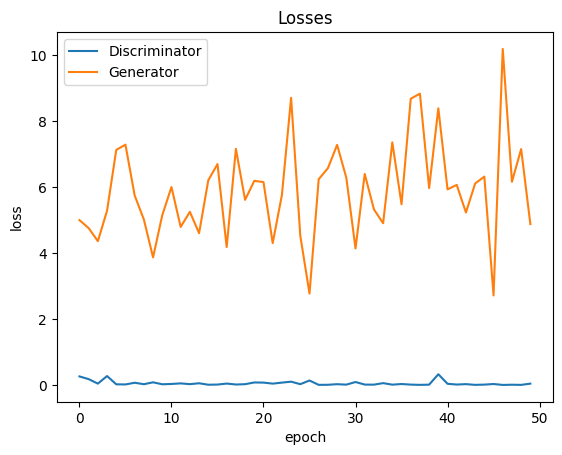

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

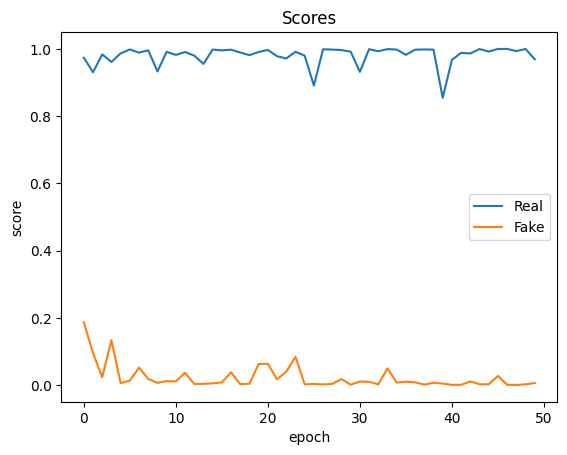

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [ ]:
!zip -r /content/generated.zip /content/generated
from google.colab import files

files.download("/content/generated.zip")

updating: content/generated/ (stored 0%)
updating: content/generated/generated-images-0024.png (deflated 0%)
updating: content/generated/generated-images-0019.png (deflated 0%)
updating: content/generated/generated-images-0017.png (deflated 0%)
updating: content/generated/generated-images-0039.png (deflated 0%)
updating: content/generated/generated-images-0029.png (deflated 0%)
updating: content/generated/generated-images-0015.png (deflated 0%)
updating: content/generated/generated-images-0042.png (deflated 0%)
updating: content/generated/generated-images-0004.png (deflated 0%)
updating: content/generated/generated-images-0007.png (deflated 0%)
updating: content/generated/generated-images-0016.png (deflated 0%)
updating: content/generated/generated-images-0003.png (deflated 0%)
updating: content/generated/generated-images-0043.png (deflated 0%)
updating: content/generated/generated-images-0012.png (deflated 0%)
updating: content/generated/generated-images-0049.png (deflated 0%)
updatin

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('/content/D.pth')
files.download('/content/G.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>